# Table of contents

1. [Introduction](#Introduction) <br>
2. [Imports](#imports)<br>
3. [Data Acquisition](#data_acquisition)<br>
   3.1 [Scraping Challanges](#scraping_challanges)<br>
   3.2 [Util Functions](#util_functions)<br>
   3.3 [Scraping Process](#scraping_process)<br>
   3.4 [Crawling](#crawling)<br>
   3.5 [Data Scraped](#data_scraped)<br>
4. [Data Cleaning](#data_cleaning)<br>
   4.1 [Data NA to Real NA](#data_na_to_real_na)<br>
   4.2 [Cleaning and Converting](#cleaning_and_converting)<br>
   4.3 [Converting to Categorical](#categorical_conversion)<br>
   4.4 [Removing Duplicates](#removing_duplicates)<br>
   4.5 [Filling in missing values](#filling_in_missing_values)<br>
5. [EDA](#eda)<br>
   5.1 [Numeric fields Correlation to Price](#numeric_correlation)<br>
   5.2 [CPU Speed distribution](#cpu_speed_distribution)<br>
   5.3 [Brands Distribution](#brands_distribution)<br>
   5.4 [Mean price by brand](#mean_price_by_brand_)<br>
   5.5 [Screen size distribution](#screen_size_distribution)<br>
   5.6 [Mean price by screen size](#mean_price_by_screen_size)<br>
   5.7 [Mean price by Number of cores](#mean_price_by_moc)<br>
   5.8 [Mean price by series](#mean_price_by_series)<br>
6. [Machine Learning](#machine_learning_prep)<br>
   6.1 [Classification](#classification)<br>
   6.2 [Helper Functions](#ml_helper_functions)<br>
   6.3 [Predictions](#predictions)<br>
7. [Conclusion](#conclusion)<br>

<a name='introduction'></a>
# Introduction
<p>
    In this project, we aim to analyze the prices of phones in the market and identify the factors that have the most significant impact on these prices. With numerous phones available, each with varying prices, brands, operating system, and screen types, we are curious to understand which aspects contribute the most to the price differences. Is it the brand, camera quality, or something as seemingly trivial as the type of RAM or other specifications?<br>
    <br>
    Our research goal is two-fold: first, to determine if we can develop a model that accurately predicts the price of a phone based on its specifications, and second, to identify the critical elements within these specifications that heavily influence the price.<br>
    <br>
    By investigating these questions, we aim to gain insights into the factors driving phone prices and ultimately create a predictive model that can estimate a phone's price based on its specific features.<br>
</p>

<a id='imports'></a>
<h2 id="imports">Imports</h2>

In [2]:
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
from random import randint
import time
from time import sleep
from typing import List
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn import linear_model, metrics, preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import r2_score, f1_score

<a id="data_acquisition"></a>
<h2>Data Acquisition</h2>
<p>Considering our options of data acquisition sources, we decided to look for the biggest electronics comparsion websites and scrape data which we thought will be helpful and save it as a dataframe.

The top options we found were:</p>
<ul>
   <li> <a href="https://zap.com/"target="_blank">Zap</a></li>
    <li><a href="https://amazon.com/"target="_blank">Amazon</a></li>
    <li><a href="https://www.ret.co.il/"target="_blank">Ret</a></li>
    <li><a href="https://www.gadgetsnow.com/"target="_blank">gadgetsnow</a></li>
    <li><a href="https://www.wisebuy.co.il/"target="_blank">wisebuy</a></li>
</ul>

<p>After a punctual search in these websites for relevant data and great community scale, we have decided to move on with Zap And Ret due to the popularity of the sites and the amount of features provided for each phones.</p>




<a id='scraping_challanges'></a>
<h3>Scraping challanges</h3>
<p>On our first attempts to scrape the data from Zap and Ret we incounterd the following issues:<br>
    <ul>
       <li> When sending too many requests in a short period of time, the websites started to slow down and the scraping took a long period of time.</li>
        <li>The default user agent used by requests was python: "requests/2.26.0" and we were blocked by Zap and Ret after a few requests.</li>
     </ul>
</p>
<p> The way we dealed with those issues was by using sleep and a custom header.

<a id='util_functions'></a>

<h3>
Some Util functions to help scrape the data:
</h3>
<p>
    <ul>
        <li>"sleepms"- a function made in order to create a delay so the amount of requests sends to the server in parralel will not affect the scraping performance and other users experience in the website</li>
        <li>"random_wait"- a function which is used in order to create random delay so our scraping methodology will not be detected by the servers.</li>
       <li> "get_fake_user_agent"- a function which provides us with a non suspectable user agent.</li>

In [3]:
def sleepms(milliseconds: int):
    seconds = 0.001 * milliseconds
    sleep(seconds)
    
def random_wait():
    sleepms(randint(1, 250))

def get_fake_user_agent():
    # phone user agent
    return {"User-Agent":"Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/111.0.0.0 Mobile Safari/537.36"}

<a id='scraping_process'></a>
<h3>Scraping Process</h3>
<p>
We went into the website and started exploring in order to find the best route for our scraping proccess.
</p>
<p>
We could clearly see that our best option to get maximum data was in the extra details page which contains huge amount of data.<br>
</p>

</p>
At this point we asked ourselves what is the exact data we wish to scrape?<br>

we decided to go with the following and rename them for the rest of the process:
<ul>     
    <li>יצרן - Brand</li>
    <li>שנת הכרזה – Out date</li>
    <li>מערכת הפעלה - Operating System</li>
    <li>משקל - Weight</li>
    <li>סדרה – Series</li>
    <li>טלפון חכם-SmartPhone</li>
    <li>ממשק הפעלה-Operating interface</li>
    <li>נפח זיכרון RAM - RAM Capacity</li>
    <li>מהירות מעבד - CPU speed</li>
    <li>דור- generation</li>
    <li>גודל מסך - Screen Size</li>
    <li>מספר ליבות – number of cores</li>
    <li>רזולוצית מסך - Screen Resolution</li>
    <li>צפיפות פיקסלים  - pixels</li>
    <li>סוג מסך - Screen Type</li>
    <li>קצב ריענון תצוגה - FPS</li>
    <li>עמידות במים – Water resistance</li>
    <li>צבע – colors</li>
    <li>כרטיס זיכרון - GPU</li>
    <li>מצלמה קדמית – Front Camera</li>
    <li>מצלמה–Camera</li>
    <li>קורא טביעת אצבע - Fingerprint reader</li>
    <li>רשת אלחוטית - Wifi modal</li>
    <li>מחיר מינימלי - Min price</li>
    <li>מחיר מקסימלי - Max price</li>
    <li>קורא כרטיסים – NFC</li>
    <li>Bluetooth</li>
    <li>קיבולת סוללה - Battery capacity</li>
</ul>
Also, we decided to save the page number in which Zap and Rat decided to place the phones, maybe it has a meaning we could use:
<ul>
    <li>Page Number</li>
</ul>


```python
# ZAP
def zap_crawl_data(BASE_URL,phone_id):
    price_detail = requests.get(f'{BASE_URL}//model.aspx?modelid={phone_id}',headers = get_fake_user_agent())
    price_soup = BeautifulSoup(price_detail.text, 'html.parser')
    spans = price_soup.find('div',attrs={'class':'prices-txt'}).find_all('span',limit=None)
    titles = ['מחיר מינימלי','מחיר מקסימלי']
    if len(spans) == 3:
        values = [ spans[1].text, spans[0].text ]
    elif len(spans) == 2: 
        values = [ spans[0].text, spans[0].text ]
    else:
        return None


    phone_detail = requests.get(f'{BASE_URL}//compmodels.aspx?modelid={phone_id}',headers = get_fake_user_agent())
    phone_soup = BeautifulSoup(phone_detail.text, 'html.parser').find('div',attrs={'class':'compareBox'})
    links = phone_soup.find_all('div', attrs={'class' : 'paramRow'},limit=None)
    
    for i in range(0, len(links)):
        titles.append(links[i].find('div',attrs={'class' : 'ParamCol'}).text.replace('?','').strip())
        values.append(links[i].find('div',attrs={'class' : 'ParamColValue'}).text.strip())

    return dict(zip(titles,values))

# RET
def ret_crawl_data(BASE_URL,phone_id):
    url = f'{BASE_URL}m/{phone_id}/specs'
    page = requests.get(url,headers = get_fake_user_agent())
    soup = BeautifulSoup(page.text, 'html.parser')
    meta = soup.find('div',attrs={'class','price'})
    lowPrice = meta.find('meta',attrs={'itemprop':'lowPrice'})
    highPrice = meta.find('meta',attrs={'itemprop':'highPrice'})
    if(lowPrice == None or highPrice == None):
        return None
    titles = ['מחיר מינימלי','מחיר מקסימלי']
    values = [lowPrice.get('content'),highPrice.get('content')]
    properties = soup.find('div',attrs={'class','single-product-tab'}).find_all('ul',attrs={'class':'list-group list-group-horizontal'},limit=None)
    for i in range(0,len(properties)):
        [title,value] = properties[i].find_all('li',limit=None)
        titles.append(title.text.strip())
        values.append(value.text.strip()) 
    
    return dict(zip(titles,values))
```

In [4]:
def translate_names(df):
    translated_df = pd.DataFrame()
    translation = {
        "יצרן": "Brand",
        "שנת הכרזה": "Out Date",
        "מערכת הפעלה": "Operating System",
        "משקל": "Weight",
        "סדרה": "Series",
        "Smartphone": "Smartphone",
        "ממשק הפעלה": "Operating interface",
        "זיכרון RAM": "RAM Capacity",
        "מהירות מעבד": "CPU speed",
        "דור": "CPU generation",
        "גודל מסך": "Screen Size",
        "מספר ליבות": "Number of cores",
        "רזולוציה": "Screen Resolution",
        "צפיפות פיקסלים": "pixels",
        "קצב רענון": "FPS",
        "סוג מסך": "Screen Type",
        "עמידות במים": "Water resistance",
        "צבעים": "Colors",
        "כרטיס זיכרון": "GPU",
        "מצלמה קדמית": "Front camera",
        "מצלמה": "Camera",
        "קורא טביעת אצבע": "Fingerprint reader",
        "WiFi": "WiFi",
        "מחיר מינימלי": "Min price",
        "מחיר מקסימלי": "Max price",
        "NFC": "NFC",
        "Bluetooth": "Bluetooth",
        "קיבולת הסוללה": "Battery capacity",
        "מספר עמוד": "Page number"}
    df.rename(columns=translation,inplace=True)
    for col in translation.values():
        translated_df[col] = df[col]
    return translated_df

<a id='crawling'></a>
<h3>Crawling</h3>
<p>
At this point, we considered different tools for crawling data from zap and ret:
<ul>
<li>BeautifulSoup - a library in python that allows to crawl data via xpath in a simple way</li>
<li>Scrapy - a free open source web-crawling framework written in python, the library allows crawling for data via xpath </li>
<li>Selenum - a tool for automation testing, the selenuim framework is divided into two parts: selenuim sdk and chrome driver. This tool also allows crawling for data via xpath </li>
</ul>

Eventually, we chose BeautifulSoup.
</p>

```python
# ZAP
def zap_data_crawl_all(BASE_URL,filename,page):
    index = page
    df = pd.DataFrame()
    url = f'{BASE_URL}models.aspx?sog=e-cellphone&pageinfo={index}'
    page = requests.get(url,headers = get_fake_user_agent())
    soup = BeautifulSoup(page.text, 'html.parser')
    last_page = int(soup.find('div',attrs={'class':'paging'}).find('select').find_all('option',limit=None)[-1].text)
    for i in range(index,last_page+1):
        a_tags = soup.find('div',attrs={'id':'divSearchResults'}).find_all('a',limit=None)
        phone_id = [tag.get('data-model-id') for tag in a_tags] 
        for i in range(0, len(phone_id)):
            cd = zap_crawl_data(BASE_URL,phone_id[i])
            if(cd is not None):
                cd['מספר עמוד'] = index
                df = pd.concat([df,pd.DataFrame([cd])])
        index += 1
        random_wait()
        url = f'{BASE_URL}models.aspx?sog=e-cellphone&pageinfo={index}'
        page = requests.get(url,headers = get_fake_user_agent())
        soup = BeautifulSoup(page.text, 'html.parser')
    translated_df = translate_names(df)
    translated_df.to_csv(filename, index=False, mode='a', header=False ,encoding = 'utf:"8:"sig')
# RET
def ret_data_crawl_all(BASE_URL,filename,page):
    index = page
    df = pd.DataFrame()
    url = f'{BASE_URL}shop/cellphone?pageindex={index}'
    page = requests.get(url,headers = get_fake_user_agent())
    soup = BeautifulSoup(page.text, 'html.parser')
    last_page =  int(soup.find('nav',attrs={'class':'card-pagination'}).find('div').text.split(' ')[-1])
    for i in range(index,last_page+1):
        phone_divs = soup.find('div',attrs={'class':'product-list'}).find_all('div',attrs={'class':'shop-block'},limit=None)
        phone_id = [div.get('data-id') for div in phone_divs]
        for i in range(0, len(phone_id)):
            cd = ret_crawl_data(BASE_URL,phone_id[i])
            if(cd is not None):
                cd['מספר עמוד'] = index
                df = pd.concat([df,pd.DataFrame([cd])])
        index += 1
        random_wait()
        url = f'{BASE_URL}shop/cellphone?pageindex={index}'
        page = requests.get(url,headers = get_fake_user_agent())
        soup = BeautifulSoup(page.text, 'html.parser')
    translated_df = translate_names(df)
    translated_df.to_csv(filename, index=False,mode='a', header=False,encoding = 'utf:"8:"sig') 
```

In [5]:
ZAP_BASE_URL ="https://www.zap.co.il/"
zap_filename = './data/zap_data.csv'
zap_page = 1

RET_BASE_URL = "https://www.ret.co.il/"
ret_filename = './data/ret_data.csv'
ret_page = 1

```python
zap_data_crawl_all(ZAP_BASE_URL, zap_filename, zap_page)
ret_data_crawl_all(RET_BASE_URL, ret_filename, ret_page)
```

<a id='data_scraped'></a>
<h3>Let's check how much data did we scrape before we start cleaning it (if needed)</h3>

In [6]:
zap_df = pd.read_csv(zap_filename)
ret_df = pd.read_csv(ret_filename)
# zap_df['Page number'] = zap_df['Page number'].apply(lambda x: "zap_"+str(x))
# ret_df['Page number'] = ret_df['Page number'].apply(lambda x: "ret_"+str(x))
phones_df = pd.concat([zap_df,ret_df],ignore_index=True)
print(f"df shape:{phones_df.shape}")
print(f"data amount before cleaning: {'{:,}'.format(phones_df.shape[0] * phones_df.shape[1])} (rows * cols)")
phones_df.head()

df shape:(2174, 29)
data amount before cleaning: 63,046 (rows * cols)


,Brand,Out Date,Operating System,Weight,Series,Smartphone,Operating interface,RAM Capacity,CPU speed,CPU generation,...,Front camera,Camera,Fingerprint reader,WiFi,Min price,Max price,NFC,Bluetooth,Battery capacity,Page number
0,Samsung,2022,Android,177 גרם,Galaxy S21,סמארטפון,מסך מגע,8GB,1800 2420 2840 MHz,4,...,32 מגה פיקסל,12 +8 + 12 מגה פיקסל,כולל,כולל,"1,444","2,529",כולל,כולל,"4,500 mAh",1
1,Xiaomi,2022,Android,179 גרם,Redmi Note 11,סמארטפון,מסך מגע,6GB,1900 2400 MHz,4,...,13 מגה פיקסל,50 + 8 + 2 + 2 מגה פיקסל,כולל,כולל,680,999,אופציונאלי,5.0,"5,000 mAh",1
2,Samsung,2023,Android,234 גרם,Galaxy S23 Ultra,סמארטפון,מסך מגע,512MB,2800 2800 3360 MHz,5,...,12 מגה פיקסל,200 + 10 + 10 +12 מגה פיקסל,כולל,כולל,"4,489","5,425",אופציונאלי,5.3,"5,000 mAh",1
3,Samsung,2023,Android,234 גרם,Galaxy S23 Ultra,סמארטפון,מסך מגע,12GB,2000 2800 2800 3360 MHz,5,...,12 מגה פיקסל,200 + 10 + 10 +12 מגה פיקסל,כולל,כולל,"4,005","4,925",אופציונאלי,5.3,"5,000 mAh",1
4,Samsung,2022,Android,228 גרם,Galaxy S22,סמארטפון,מסך מגע,12GB,1700 2400 3000 MHz,4,...,40 מגה פיקסל,108 + 10 + 10 + 12 מגה פיקסל,כולל,כולל,"3,418","4,589",כולל,5.2,"5,000 mAh",1


<a id='data_cleaning'></a>
<h2>Data Cleaning</h2>


<a id='data_na_to_real_na'></a>

<h3>Turning Zap's NA's and Ret NA's to real NA's</h3>

In [7]:
phones_real_na = phones_df.copy()
for col in phones_real_na:
    phones_real_na.loc[(phones_real_na[col] == 'לא זמין') | (phones_real_na[col] == 'יעודכן בקרוב') | (phones_real_na[col] == 'ללא') | (phones_real_na[col] == "לא רלוונטי"), col] = None 
    phones_real_na.loc[(phones_real_na[col] == 'כולל')| (phones_real_na[col] == 'אופציונאלי'), col] = 1 

<a id='cleaning_and_converting'></a>

<h3>Cleaning and converting to numeric</h3>

In [8]:
def remove_junk(col):
    if(col):
        return str(col).replace('\u200f','')
    return col

def sum_col(col):
    col = remove_junk(col)
    if col == 'None' or col == '':
        return None
    col_string = col.split(' ')
    ret_sum = 0
    for i in range(0,len(col_string)):
        try:
            ret_sum += float(col_string[i])
        except ValueError:
            print(col_string)
    return str(ret_sum)

def multiplay_col(col):
    if(col == 'None' or col==''):
        return None
    [num1,num2] = remove_junk(col).lower().split('x')
    return str(float(num1)*float(num2))    

def ignore_non_numeric_chars(df,col,ignore_str = r"[^0-9.]",replace=''):
    return df[col].astype(str).str.replace(ignore_str,replace, regex=True).str.strip()

def cleaning_and_converting(df):
    df = df.copy()
    df['Out Date'] = pd.to_numeric(df['Out Date'])
    
    df['Weight'] = pd.to_numeric(ignore_non_numeric_chars(df=df,col='Weight'))
    

    df['Smartphone'] = ignore_non_numeric_chars(df=df,col='Smartphone',ignore_str=r'None',replace='')
    
    df['RAM Capacity'] = ignore_non_numeric_chars(df=df,ignore_str=r'512MB',replace='0.512',col='RAM Capacity')
    df['RAM Capacity'] = pd.to_numeric(ignore_non_numeric_chars(df=df,col='RAM Capacity'))


    
    df['CPU speed'] = ignore_non_numeric_chars(df=df,col='CPU speed',ignore_str=r'MHz|nan')
    df['CPU speed'] = pd.to_numeric(df['CPU speed'].apply(sum_col))

    df['CPU generation'] = pd.to_numeric(ignore_non_numeric_chars(df=df,col='CPU generation',ignore_str=r'[0-9], |None|nan'))
    
    df['Screen Size'] = pd.to_numeric(ignore_non_numeric_chars(df=df,col='Screen Size'))
    df['Number of cores'] = ignore_non_numeric_chars(df=df,col='Number of cores',ignore_str=r'ליבות|\+ |ליבה|nan')
    df['Number of cores'] = ignore_non_numeric_chars(df=df,col='Number of cores',ignore_str=r'אחת',replace='1')
    df['Number of cores'] = ignore_non_numeric_chars(df=df,col='Number of cores',ignore_str=r'\+',replace=' ')
    df['Number of cores'] = ignore_non_numeric_chars(df=df,col='Number of cores',ignore_str=r'Octa-core',replace='8')
    df['Number of cores'] = pd.to_numeric(df['Number of cores'].apply(sum_col))
    
    df['Screen Resolution'] = ignore_non_numeric_chars(df=df,col='Screen Resolution',ignore_str=r'פיקסלים|nan')
    df['Screen Resolution'] = pd.to_numeric(df['Screen Resolution'].apply(multiplay_col)) 
    
    df['pixels'] = ignore_non_numeric_chars(df=df,col='pixels',ignore_str=r'None')
    df['pixels'] = pd.to_numeric(ignore_non_numeric_chars(df=df,col='pixels',ignore_str=r'ppi|nan'))
    
    df['FPS'] = pd.to_numeric(ignore_non_numeric_chars(df=df,col='FPS',ignore_str=r'None|Hz|nan'))
        
    df['Front camera'] = df['Front camera'].apply(remove_junk)
    
    df['Front camera'] = ignore_non_numeric_chars(df=df,col='Front camera',ignore_str=r'לא כולל מגה פיקסל',replace='0')
    df['Front camera'] = ignore_non_numeric_chars(df=df,col='Front camera',ignore_str=r'כולל מגה פיקסל',replace='1')
    df['Front camera'] = pd.to_numeric(ignore_non_numeric_chars(df=df,col='Front camera',ignore_str=r'\+ |nan|מגה פיקסל').apply(sum_col))
    df['Camera'] = ignore_non_numeric_chars(df=df,col='Camera',ignore_str=r'\+ |צגה פיקסל|ים|מ|גה|nan|פיקסל')
    df['Camera'] = ignore_non_numeric_chars(df=df,col='Camera',ignore_str=r" \+",replace=' ')
    df['Camera'] = pd.to_numeric(ignore_non_numeric_chars(df=df,col='Camera',ignore_str=r"\+",replace=' ').apply(sum_col))
    
    df['NFC'] = pd.to_numeric(df['NFC'])

    df['Bluetooth'] = ignore_non_numeric_chars(df=df,col='Bluetooth',ignore_str=r'לא כולל',replace='0')
    df['Bluetooth'] = pd.to_numeric(ignore_non_numeric_chars(df=df,col='Bluetooth',ignore_str=r'None|nan'))
    
    df['Battery capacity'] = pd.to_numeric(ignore_non_numeric_chars(df=df,col='Battery capacity',ignore_str=r'mAh|,|None|nan'))
    
    df['Min price'] = pd.to_numeric(ignore_non_numeric_chars(df=df,col='Min price',ignore_str=r',|nan'))
    df['Max price'] = pd.to_numeric(ignore_non_numeric_chars(df=df,col='Max price',ignore_str=r',|nan'))
    # #return df['NFC']
    return df


cleaning_and_converting(phones_real_na).head()


,Brand,Out Date,Operating System,Weight,Series,Smartphone,Operating interface,RAM Capacity,CPU speed,CPU generation,...,Front camera,Camera,Fingerprint reader,WiFi,Min price,Max price,NFC,Bluetooth,Battery capacity,Page number
0,Samsung,2022.0,Android,177.0,Galaxy S21,סמארטפון,מסך מגע,8.000,7060.0,4.0,...,32.0,32.0,1,1,1444,2529,1.0,1.0,4500.0,1.0
1,Xiaomi,2022.0,Android,179.0,Redmi Note 11,סמארטפון,מסך מגע,6.000,4300.0,4.0,...,13.0,62.0,1,1,680,999,1.0,5.0,5000.0,1.0
2,Samsung,2023.0,Android,234.0,Galaxy S23 Ultra,סמארטפון,מסך מגע,0.512,8960.0,5.0,...,12.0,232.0,1,1,4489,5425,1.0,5.3,5000.0,1.0
3,Samsung,2023.0,Android,234.0,Galaxy S23 Ultra,סמארטפון,מסך מגע,12.000,10960.0,5.0,...,12.0,232.0,1,1,4005,4925,1.0,5.3,5000.0,1.0
4,Samsung,2022.0,Android,228.0,Galaxy S22,סמארטפון,מסך מגע,12.000,7100.0,4.0,...,40.0,140.0,1,1,3418,4589,1.0,5.2,5000.0,1.0


<a id='categorical_conversion'></a>
<h3>Converting to Categorical</h3>

In [9]:

categorical_phones = cleaning_and_converting(phones_real_na)
categorical_phones['Water resistance'] = pd.to_numeric(categorical_phones['Water resistance'].apply(lambda col: 0 if col is None else 1))

categorical_phones['NFC'] = pd.to_numeric(categorical_phones['NFC'])

categorical_phones['Smartphone'] = np.where(categorical_phones['Smartphone'].str.strip()  == 'סמארטפון', 1 , 0)

categorical_phones['Fingerprint reader'] = pd.to_numeric(categorical_phones['Fingerprint reader'].fillna(0))

categorical_phones['NFC'] = pd.to_numeric(categorical_phones['NFC'].fillna(0))

categorical_phones['WiFi'] = pd.to_numeric(np.where(categorical_phones['WiFi'] != 1,0,1))

categorical_phones.head()

,Brand,Out Date,Operating System,Weight,Series,Smartphone,Operating interface,RAM Capacity,CPU speed,CPU generation,...,Front camera,Camera,Fingerprint reader,WiFi,Min price,Max price,NFC,Bluetooth,Battery capacity,Page number
0,Samsung,2022.0,Android,177.0,Galaxy S21,1,מסך מגע,8.000,7060.0,4.0,...,32.0,32.0,1,1,1444,2529,1.0,1.0,4500.0,1.0
1,Xiaomi,2022.0,Android,179.0,Redmi Note 11,1,מסך מגע,6.000,4300.0,4.0,...,13.0,62.0,1,1,680,999,1.0,5.0,5000.0,1.0
2,Samsung,2023.0,Android,234.0,Galaxy S23 Ultra,1,מסך מגע,0.512,8960.0,5.0,...,12.0,232.0,1,1,4489,5425,1.0,5.3,5000.0,1.0
3,Samsung,2023.0,Android,234.0,Galaxy S23 Ultra,1,מסך מגע,12.000,10960.0,5.0,...,12.0,232.0,1,1,4005,4925,1.0,5.3,5000.0,1.0
4,Samsung,2022.0,Android,228.0,Galaxy S22,1,מסך מגע,12.000,7100.0,4.0,...,40.0,140.0,1,1,3418,4589,1.0,5.2,5000.0,1.0


<a id='removing_duplicates'></a>
<h3>Removing Duplicates</h3>

In [10]:
phones_no_dup = categorical_phones[categorical_phones.duplicated()]

<p>Lets see how many rows did we lose and the NA count:</p>

In [11]:
phones_no_dup[phones_no_dup.notna().sum().sort_values().index].info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1108 entries, 8 to 2173
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   FPS                  462 non-null    float64
 1   GPU                  497 non-null    object 
 2   Colors               516 non-null    object 
 3   CPU speed            700 non-null    float64
 4   Series               705 non-null    object 
 5   Number of cores      769 non-null    float64
 6   Out Date             820 non-null    float64
 7   Battery capacity     843 non-null    float64
 8   Camera               853 non-null    float64
 9   RAM Capacity         902 non-null    float64
 10  Screen Type          912 non-null    object 
 11  Screen Resolution    914 non-null    float64
 12  Operating System     915 non-null    object 
 13  pixels               924 non-null    float64
 14  Weight               928 non-null    float64
 15  CPU generation       937 non-null    f

<p>It appears that we do have duplicate entries. Let's proceed with reviewing the NA's (missing values) as well:</p>

In [12]:
phones_no_dup.describe()

,Out Date,Weight,Smartphone,RAM Capacity,CPU speed,CPU generation,Screen Size,Number of cores,Screen Resolution,pixels,...,Front camera,Camera,Fingerprint reader,WiFi,Min price,Max price,NFC,Bluetooth,Battery capacity,Page number
count,820.000000,928.000000,1108.000000,902.000000,700.000000,937.000000,947.000000,769.000000,9.140000e+02,924.000000,...,943.000000,853.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,939.000000,843.000000,1108.000000
mean,2019.971951,185.802047,0.819495,6.857064,5182.093000,4.192102,6.133886,7.629389,2.519072e+06,393.010823,...,14.397031,54.573634,0.674188,0.836643,1576.152527,1944.588448,0.714801,4.822471,4209.015421,8.618231
std,2.426038,33.291291,0.384782,4.147681,1915.982129,0.509442,1.099660,1.121160,1.097944e+06,88.665964,...,9.309362,38.913386,0.468889,0.369858,1212.102972,1529.288917,0.451713,0.874354,1166.611072,5.389735
min,2002.000000,69.800000,0.000000,0.512000,1.100000,2.000000,1.430000,1.000000,1.638400e+04,111.000000,...,0.000000,0.300000,0.000000,0.000000,29.000000,29.000000,0.000000,0.000000,430.000000,1.000000
25%,2019.000000,175.000000,1.000000,4.000000,4000.000000,4.000000,6.100000,8.000000,2.427840e+06,392.000000,...,8.000000,24.000000,0.000000,1.000000,714.500000,801.250000,0.000000,5.000000,3900.000000,4.000000
50%,2020.500000,189.000000,1.000000,6.000000,4400.000000,4.000000,6.500000,8.000000,2.592000e+06,402.000000,...,12.000000,54.000000,1.000000,1.000000,1250.000000,1499.000000,1.000000,5.000000,4500.000000,8.000000
75%,2021.000000,202.000000,1.000000,8.000000,7060.000000,4.000000,6.670000,8.000000,2.740500e+06,444.000000,...,16.000000,74.000000,1.000000,1.000000,2053.750000,2690.000000,1.000000,5.100000,5000.000000,12.000000
max,2023.000000,367.000000,1.000000,64.000000,10960.000000,5.000000,7.600000,10.000000,4.631040e+06,570.000000,...,58.000000,232.000000,1.000000,1.000000,7449.000000,8100.000000,1.000000,5.300000,8580.000000,22.000000


<p>
The following columns have a limited amount of data available:
<ul>
<strong>
<li>FPS</li>
<li>GPU</li>
<li>Colors</li>
</strong>
</ul>
Based on our analysis, it seems that not all of the information is necessary. Let's proceed by removing the columns that are not required.
</p>

In [13]:
phones_droped_cols = phones_no_dup.drop(['FPS','GPU','Colors'] , axis = 1) 
phones_droped_cols.dropna(how='any').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 514 entries, 8 to 1889
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Brand                514 non-null    object 
 1   Out Date             514 non-null    float64
 2   Operating System     514 non-null    object 
 3   Weight               514 non-null    float64
 4   Series               514 non-null    object 
 5   Smartphone           514 non-null    int32  
 6   Operating interface  514 non-null    object 
 7   RAM Capacity         514 non-null    float64
 8   CPU speed            514 non-null    float64
 9   CPU generation       514 non-null    float64
 10  Screen Size          514 non-null    float64
 11  Number of cores      514 non-null    float64
 12  Screen Resolution    514 non-null    float64
 13  pixels               514 non-null    float64
 14  Screen Type          514 non-null    object 
 15  Water resistance     514 non-null    in

<p>Not a big improvement... lets try filling-in the rest:</p>


<a id='filling_in_missing_values'></a>
<h3>Filling in missing values<h3>

<h4>First, lets try filling-in <strong>CPU generation</strong>:</h4>
<h5>Mean or Median?</h5>
<p>
    In order to decide in which metric to replace <strong>CPU generation</strong> (mean/median) we want to replace NA values we wanted to base our decision over the distribution of the metric.
</p>

2.0
5.0


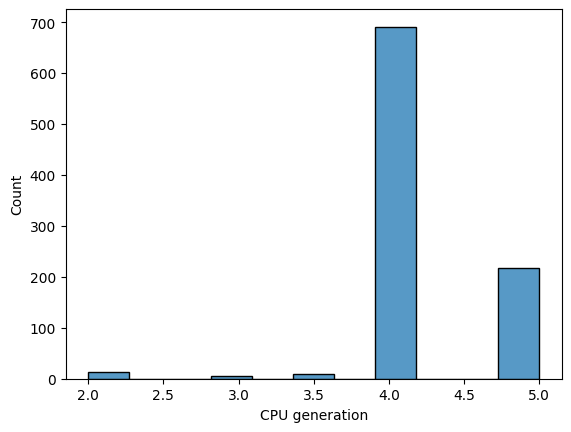

In [14]:
print(phones_droped_cols['CPU generation'].min())
print(phones_droped_cols['CPU generation'].max())

sns.histplot(phones_droped_cols['CPU generation'])
plt.show()

<p>It seems like CPU 4 generation is the right choice to fill-in the NA's so we'll go with that</p>

In [15]:
most_freq_CPU_generation = phones_droped_cols['CPU generation'].mode()[0]
phones_droped_cols['CPU generation'] = phones_droped_cols['CPU generation'].fillna(most_freq_CPU_generation)


<h3>Lets do the same for <strong>CPU speed</strong>:</h3>


1.1
10960.0


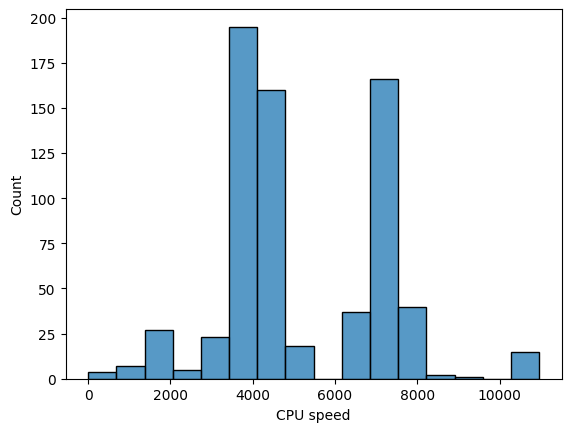

In [16]:
print(phones_droped_cols['CPU speed'].min())
print(phones_droped_cols['CPU speed'].max())

sns.histplot(phones_droped_cols['CPU speed'])
plt.show()

<p>
As we can see, The distribution analysis indicates that there is a limited presence of outliers. Therefore, we will utilize the mean for our calculations.
</p>

In [17]:
cpu_speed_mean = phones_droped_cols['CPU speed'].mean()

phones_droped_cols['CPU speed'] = np.where(
    phones_droped_cols['CPU speed'].isnull(),
    cpu_speed_mean,
    phones_droped_cols['CPU speed']
)



<h3>Now, lets try filling-in <strong>Screen Type</strong> and <strong>Operating interface</strong>:</h3>
<p>
  Screen Type and Operating interface are string values, so we'll do the same for them:
</p>

In [18]:
most_freq_GPU = phones_droped_cols['Screen Type'].mode()[0]
phones_droped_cols['Screen Type'] = phones_droped_cols['Screen Type'].fillna(most_freq_GPU)

most_freq_memory_type = phones_droped_cols['Operating interface'].mode()[0]
phones_droped_cols['Operating interface'] = phones_droped_cols['Operating interface'].fillna(most_freq_memory_type)


<p>lets see how that went for us:</p>

In [19]:
phones_droped_cols.dropna(how='any').info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 556 entries, 8 to 1889
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Brand                556 non-null    object 
 1   Out Date             556 non-null    float64
 2   Operating System     556 non-null    object 
 3   Weight               556 non-null    float64
 4   Series               556 non-null    object 
 5   Smartphone           556 non-null    int32  
 6   Operating interface  556 non-null    object 
 7   RAM Capacity         556 non-null    float64
 8   CPU speed            556 non-null    float64
 9   CPU generation       556 non-null    float64
 10  Screen Size          556 non-null    float64
 11  Number of cores      556 non-null    float64
 12  Screen Resolution    556 non-null    float64
 13  pixels               556 non-null    float64
 14  Screen Type          556 non-null    object 
 15  Water resistance     556 non-null    in

In [20]:
phones_eda = phones_droped_cols.copy().dropna(how='any') 

<p>We saved 556 rows! what a success!</p>


<a id='min_max_to_price'></a>
<h3>Minimum price, Maximum price to just "Price"!</h3>
<p>
    currently, Zap and Ret provided us with <strong>Min Price</strong> and <strong>Max Price</strong><br>
    but for our predictions we will need only the <strong>Price</strong>.
</p>

In [21]:
phones_eda['Price'] = (phones_eda['Max price'] + phones_eda['Min price'])/2
phones_eda['Price'] = (phones_eda['Price'] - phones_eda['Price'].min()) / (phones_eda['Price'].max() - phones_eda['Price'].min())
phones_eda = phones_eda.drop(["Max price" , "Min price" ] , axis = 1) 

<a id='eda'></a>
<h1>EDA</h1>

<p>
    <ul>
        <li>create_heatmap - a function made in order to create and display a heatmap.</li>

In [22]:
def create_heatmap(numeric_df):
    first_col = numeric_df.pop('Price')
    numeric_df.insert(0, 'Price', first_col)
    sns.heatmap(numeric_df.corr())

<a id='numeric_correlation'></a>
<h3>Numeric fields Correlation to Price</h3>
<p>We would like now to create a heatmap in order to check the correlation of the numeric values on the price:</p>

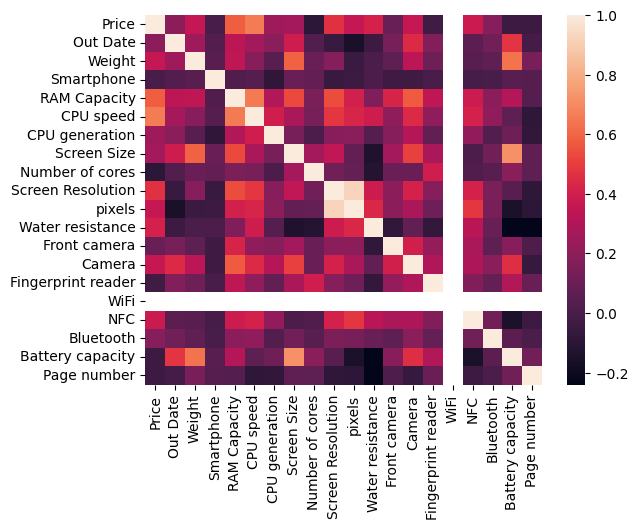

In [23]:
phones_for_heatmap = phones_eda.select_dtypes(include='number')
create_heatmap(phones_for_heatmap)

<p>As we can see, the numeric values alone won't help us in our research. but, it seems like we should look into <strong>CPU speed</strong>.<br>
<strong>RAM Capacity</strong> also has a high correlation to price. We can learn from that, that relevence affects the price as well.</p>

<a id='cpu_speed_distribution'></a>
<h3>CPU speed distribution</h3>

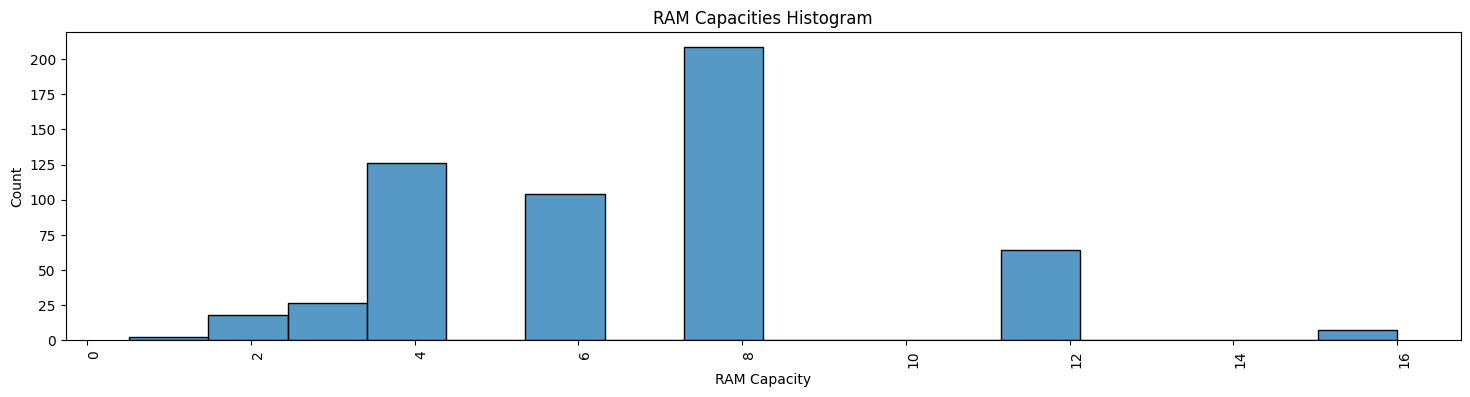

In [24]:
fig, ax = plt.subplots(figsize=(18, 4))
fg = sns.histplot(phones_eda['RAM Capacity'], ax=ax)
fg.set_title("RAM Capacities Histogram")
fg.set_xlabel("RAM Capacity")
plt.xticks(rotation=90, ha='right', rotation_mode='anchor')
plt.show()

<p>it seems that most phones are used 8GB or 4 GB of RAM.</p>

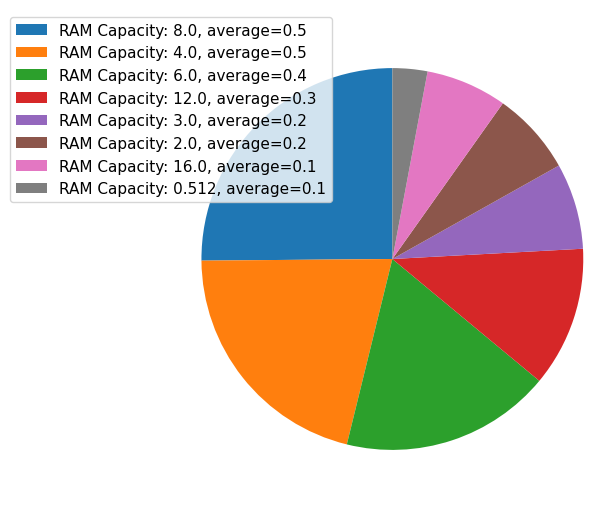

In [25]:
ram_capacity_counts = phones_eda['RAM Capacity'].value_counts()
phones_price_mean_by_ram_capacity = phones_eda.groupby('RAM Capacity', as_index=False)['Price'].mean()
phones_price_mean_by_ram_capacity.sort_values(by="Price", inplace=True, ascending=False)

labels = ["RAM Capacity: %s" % i for i in ram_capacity_counts.index]

fig1, ax1 = plt.subplots(figsize=(6, 5))
fig1.subplots_adjust(0.3,0,1,1)

_, _ = ax1.pie(phones_price_mean_by_ram_capacity['Price'].tolist(), startangle=90)

ax1.axis('equal')

plt.legend(
    loc='upper left',
    labels=['%s, average=%1.1f' % (
        l, (v)) for l, s, v in zip(labels, phones_price_mean_by_ram_capacity.index, phones_price_mean_by_ram_capacity['Price'].tolist())],
    prop={'size': 11},
    bbox_to_anchor=(0.0, 1),
    bbox_transform=fig1.transFigure
)

plt.show()

<p>We can learn from this graph that high priced phones are used 8GB and 4GB RAM. due to their distrabution we assume it's because of their populatiry</p>

<a id='brands_distribution'></a>
<h3>Brands distribution</h3>

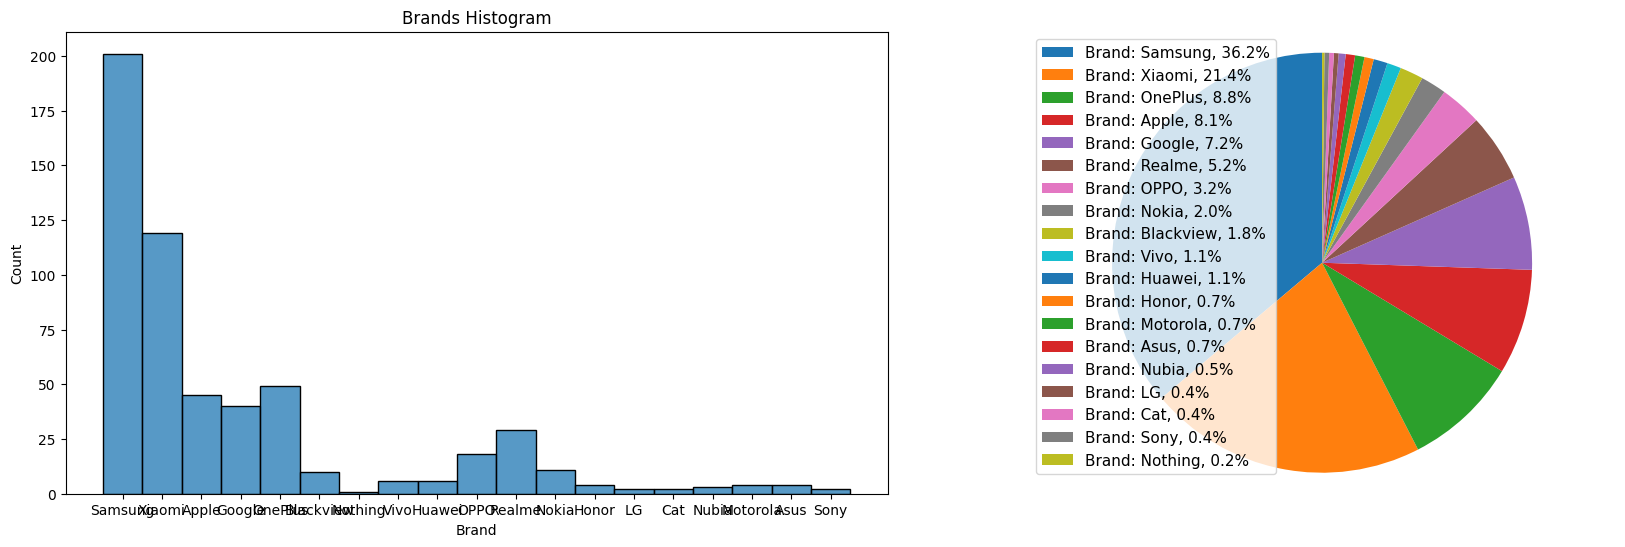

In [26]:

fig = plt.figure(figsize=(20, 6)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[3.5, 2.5]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])


#histogram:
fg = sns.histplot(phones_eda['Brand'], ax=ax1)
fg.set_title("Brands Histogram")
fg.set_xlabel("Brand")
plt.xticks(rotation=90, ha='right', rotation_mode='anchor')

phones_by_brand_count = phones_eda['Brand'].value_counts()

total_phones = phones_eda.shape[0]

labels = ["Brand: %s" % i for i in phones_by_brand_count.index]

#pie chart:
_, _ = ax2.pie(phones_by_brand_count.values, startangle=90)

ax2.axis('equal')

plt.legend(
    loc='upper left',
    labels=['%s, %1.1f%%' % (
        l, (v / total_phones * 100)) for l, s, v in zip(labels, phones_by_brand_count.index, phones_by_brand_count.values)],
    prop={'size': 11},
    bbox_to_anchor=(0.0, 1),
    # bbox_transform=fig1.transFigure
)
plt.show()

<p>as can be seen, Sumsung, Xiaomi, OnePlus and Apple are the largest "players" in the market. and LG and Huawei take a small portion of the market.</p><br>

<a id='mean_price_by_brand_'></a>

<h3>Mean price by brand</h3>

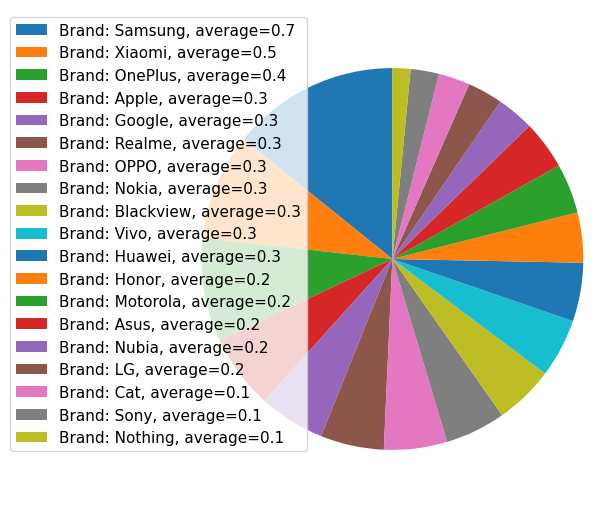

In [27]:
phones_price_mean_by_brand = phones_eda.groupby('Brand', as_index=False)['Price'].mean()
phones_price_mean_by_brand.sort_values(by="Price", inplace=True, ascending=False)

labels = ["Brand: %s" % i for i in phones_by_brand_count.index]

fig1, ax1 = plt.subplots(figsize=(6, 5))
fig1.subplots_adjust(0.3,0,1,1)

_, _ = ax1.pie(phones_price_mean_by_brand['Price'].tolist(), startangle=90)

ax1.axis('equal')

plt.legend(
    loc='upper left',
    labels=['%s, average=%1.1f' % (
        l, (v)) for l, s, v in zip(labels, phones_price_mean_by_brand.index, phones_price_mean_by_brand['Price'].tolist())],
    prop={'size': 11},
    bbox_to_anchor=(0.0, 1),
    bbox_transform=fig1.transFigure
)

plt.show()


<a id='screen_size_distribution'></a>
<h3>Screen size distribution</h3>

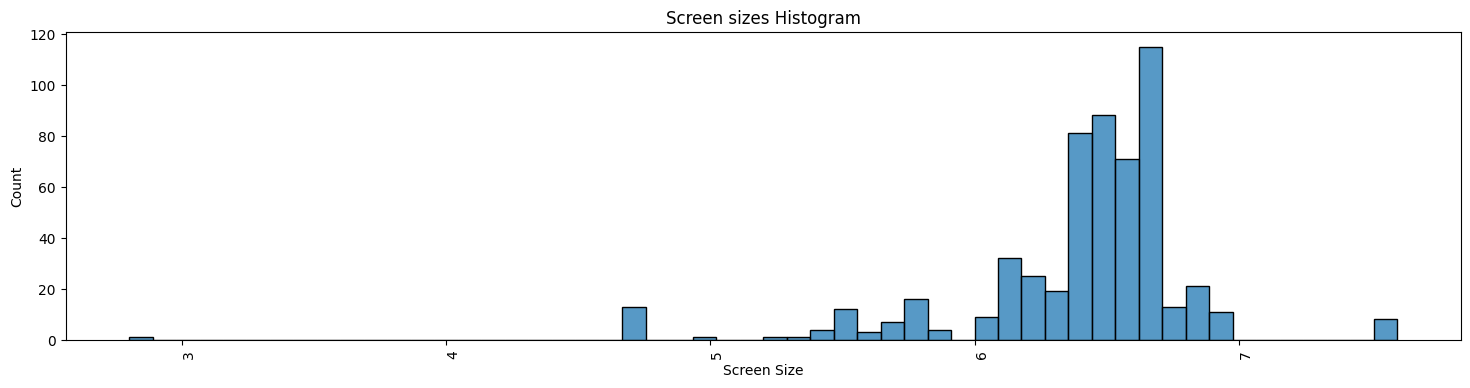

In [28]:
fig, ax = plt.subplots(figsize=(18, 4))
fg = sns.histplot(phones_eda['Screen Size'], ax=ax)
fg.set_title("Screen sizes Histogram")
fg.set_xlabel("Screen Size")
plt.xticks(rotation=90, ha='right', rotation_mode='anchor')
plt.show()

<p>It's easy to see that 6.5 to 6.8 inches are make the most of the market. next, we'll check if screen size affects the price.</p>

<a id='mean_price_by_screen_size'></a>

<h3>Mean price by screen size</h3>

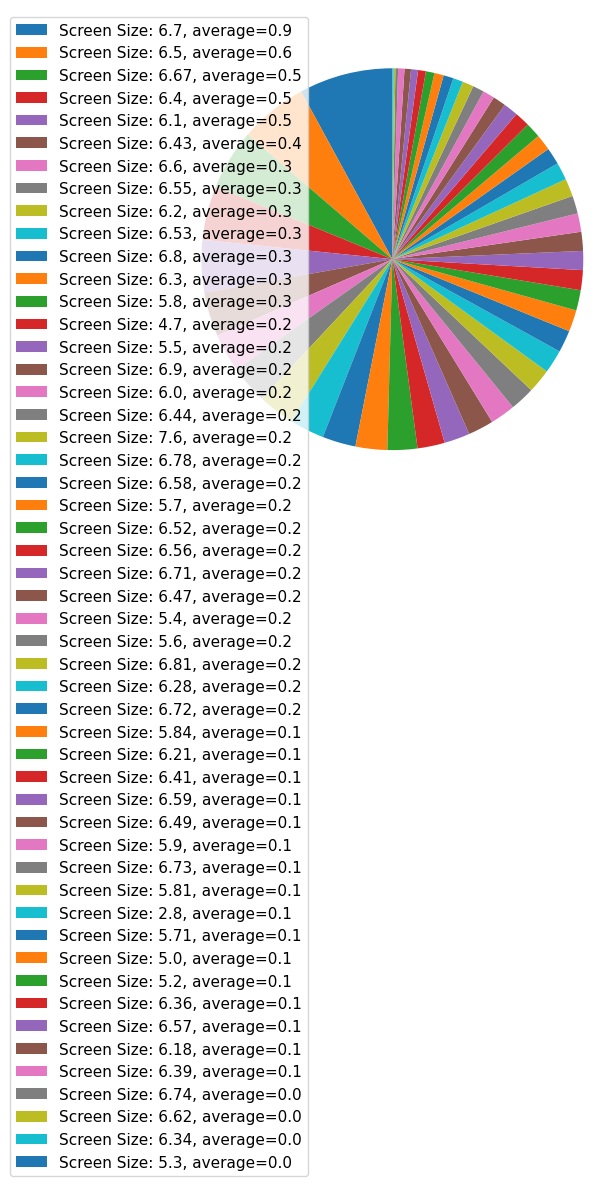

In [29]:
phones_by_screen_size_count = phones_eda['Screen Size'].value_counts()

phones_price_mean_by_screen_size = phones_eda.groupby('Screen Size', as_index=False)['Price'].mean()
phones_price_mean_by_screen_size.sort_values(by="Price", inplace=True, ascending=False)

labels = ["Screen Size: %s" % i for i in phones_by_screen_size_count.index]

fig1, ax1 = plt.subplots(figsize=(6, 5))
fig1.subplots_adjust(0.3,0,1,1)

_, _ = ax1.pie(phones_price_mean_by_screen_size['Price'].tolist(), startangle=90)

ax1.axis('equal')

plt.legend(
    loc='upper left',
    labels=['%s, average=%1.1f' % (
        l, (v)) for l, s, v in zip(labels, phones_price_mean_by_screen_size.index, phones_price_mean_by_screen_size['Price'].tolist())],
    prop={'size': 11},
    bbox_to_anchor=(0.0, 1),
    bbox_transform=fig1.transFigure
)

plt.show()


<p>It seems that the screen size does not affect the price, but considering that 5.5 to 6.8 inches are make the most of the market it's not suprising.</p>

<a id='mean_price_by_moc'></a>

<h3>Mean price by Number of cores</h3>

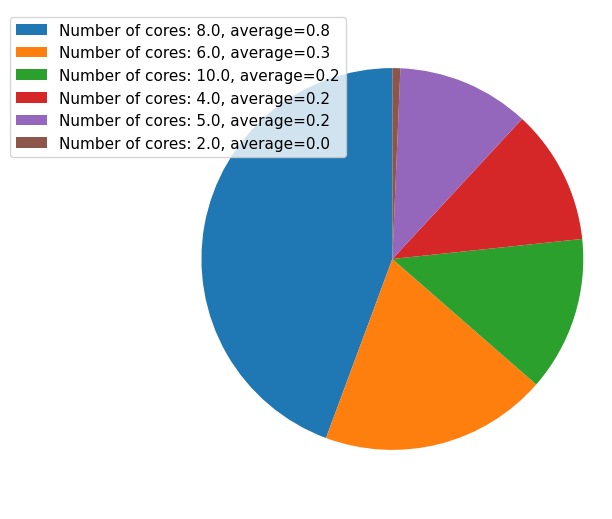

In [30]:
phones_by_num_cores_count = phones_eda['Number of cores'].value_counts()

phones_price_mean_by_num_cores = phones_eda.groupby('Number of cores', as_index=False)['Price'].mean()
phones_price_mean_by_num_cores.sort_values(by="Price", inplace=True, ascending=False)

labels = ["Number of cores: %s" % i for i in phones_by_num_cores_count.index]

fig1, ax1 = plt.subplots(figsize=(6, 5))
fig1.subplots_adjust(0.3,0,1,1)

_, _ = ax1.pie(phones_price_mean_by_num_cores['Price'].tolist(), startangle=90)

ax1.axis('equal')

plt.legend(
    loc='upper left',
    labels=['%s, average=%1.1f' % (
        l, (v)) for l, s, v in zip(labels, phones_price_mean_by_num_cores.index, phones_price_mean_by_num_cores['Price'].tolist())],
    prop={'size': 11},
    bbox_to_anchor=(0.0, 1),
    bbox_transform=fig1.transFigure
)

plt.show()


<p>it seems like num of cores affects the price!</p>

<a id='mean_price_by_series'></a>

<h3>Mean price by series</h3>

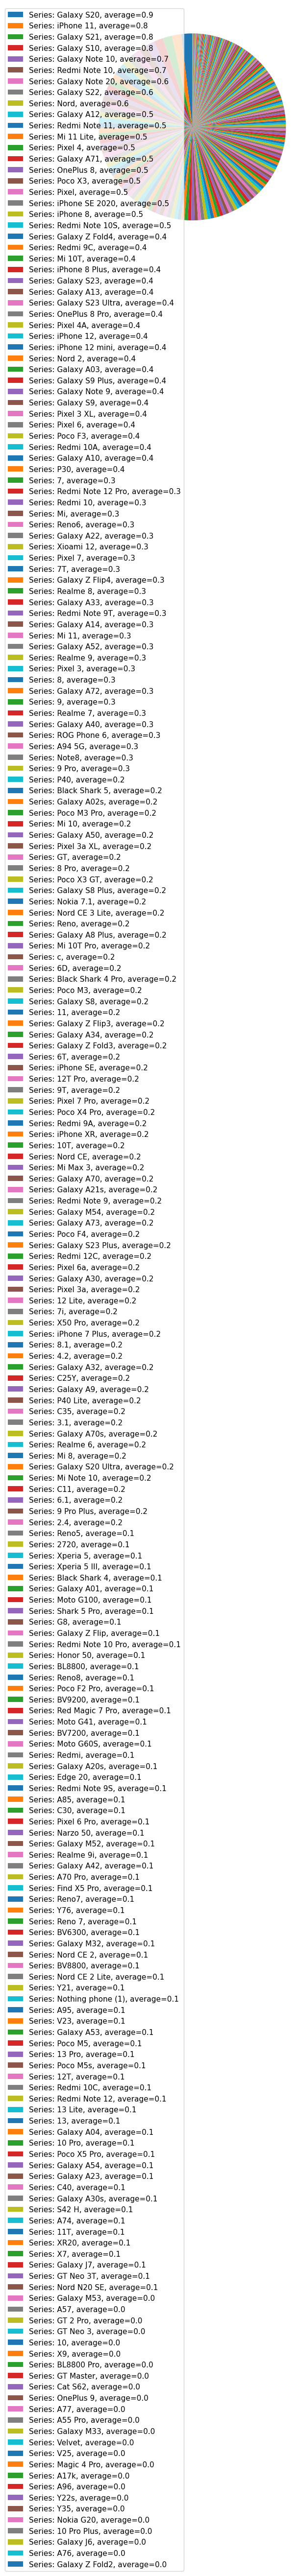

In [31]:
phones_by_series_count = phones_eda['Series'].value_counts()

phones_price_mean_by_series = phones_eda.groupby('Series', as_index=False)['Price'].mean()
phones_price_mean_by_series.sort_values(by="Price", inplace=True, ascending=False)

labels = ["Series: %s" % i for i in phones_by_series_count.index]

fig1, ax1 = plt.subplots(figsize=(6, 5))
fig1.subplots_adjust(0.3,0,1,1)

_, _ = ax1.pie(phones_price_mean_by_series['Price'].tolist(), startangle=90)

ax1.axis('equal')

plt.legend(
    loc='upper left',
    labels=['%s, average=%1.1f' % (
        l, (v)) for l, s, v in zip(labels, phones_price_mean_by_series.index, phones_price_mean_by_series['Price'].tolist())],
    prop={'size': 11},
    bbox_to_anchor=(0.0, 1),
    bbox_transform=fig1.transFigure
)

plt.show()


<p>it seems like series affects the price!</p>

<a id='machine_learning'></a>
<h1>Machine Learning</h1>

In [32]:
phones_ml = phones_eda.copy()

<a id='classification'></a>

<h3>Classification of the problem</h3>
<p>We want to predict the price of phones based on his specs.<br>
Because what we are predicting is a number, we are facing a suprivesd learning problem called:<br>
<strong>Regression on a continuous variable.</strong><br>
We can solve that problem by using: <strong>Linear Regression.</strong> 
</p>

<a id='ml_helper_functions'></a>

<h3>Helper Functions:</h3>
<p>
<ul>
    <li>train_model - trains the model </li>
    <li>evaluate_performance - evaluates the performance of the model</li>
    <li>split_to_X_and_y - splits the prediction column from the dataframe</li>
    <li>predict - prints a linear regression predicton evaluation of a dataframe using the above functions.</li>
</ul>
</p>


In [33]:
def train_model(X, y):
    reg = LinearRegression(fit_intercept = False)
    return reg.fit(X, y)

In [34]:
def evaluate_performance(y,y_predicted):
    return metrics.r2_score(y, y_predicted)

In [35]:
def split_to_X_and_y(df, target_column):
    return df.drop([target_column],axis = 1), df[target_column]

In [36]:
def predict(df):
    numeric_df = df.select_dtypes(include='number')
    X, y = split_to_X_and_y(numeric_df,'Price')
    trained_model = train_model(X, y)
    pred_vals = trained_model.predict(X)
    y_pred= pd.Series(pred_vals,index=X.index)
    eval_res = evaluate_performance(y, y_pred)
    print('amount of data:', X.shape[0] * X.shape[1])
    print('prediction:', eval_res)

<a id='predictions'></a>
<h3>Predictions</h3>

<p>First, let's use <strong>Linear Regression</strong> on the dataframe as it to see what's our current prediction:</p>

In [37]:
predict(phones_ml)

amount of data: 10564
prediction: 0.6996014292966066


<p>Lets try to improve that by adding some features:</p>

In [38]:
def features(df):
    # df['Screen Resolution'] = df['Screen Resolution'].apply(lambda s: int(s.split('x')[0]) *int(s.split('x')[1]))
    df['Screen Resolution'] = (df['Screen Resolution'] - df['Screen Resolution'].min()) / (df['Screen Resolution'].max() - df['Screen Resolution'].min())    
    return df  

<p>let's predict again:</p>

In [39]:
phones_ml_with_features = features(phones_ml.copy())
predict(phones_ml_with_features)

amount of data: 10564
prediction: 0.6996014292966075


<p>Adding features helped a bit, but it is not good enough.</p>

<p>
<ul>
    <li>categorial_to_numerical - turns a categorical column to numerical using <strong>pd.get_dummies</strong> </li>
</ul>
</p>

In [40]:
def categorial_to_numerical(df, columns):
    return pd.get_dummies(df, columns=columns)

<p>In the EDA section we saw that <strong>Series</strong> affects the price. lets try converting it to numerical and see if that helps:<br>
(by doing so, we are increasing the amount of data the model is working on, so we won't over use this method)</p>

In [41]:
phones_ml_with_categorical = categorial_to_numerical(phones_ml_with_features.copy(),['Series'])
predict(phones_ml_with_categorical)

amount of data: 139000
prediction: 0.9365224123428335


<p>lets try anoter feature to see if it has the same affect:</p>

In [42]:
phones_ml_with_categorical = categorial_to_numerical(phones_ml_with_features.copy(),['RAM Capacity'])
predict(phones_ml_with_categorical)

amount of data: 14456
prediction: 0.7165067682486288


<p>wow! also a great influnce. not as much as <strong>Series</strong> but also quite big.<br>
Also, a lot less demanding on the amount of data.</p>
<p>Lets combine them:</p>

In [43]:
phones_ml_with_categorical = categorial_to_numerical(phones_ml_with_features.copy(),['RAM Capacity','Series'])
predict(phones_ml_with_categorical)

amount of data: 142892
prediction: 0.9383776364694343


<p>We'll stop here. this is a great result and the data is getting quite big.<br>
Also, we wouldn't want to overfit the model.</p>

<a id='conclusion'></a>
<h2>Conclusion</h2>

In [44]:
phones_conclusion = phones_ml[['Price','Screen Resolution','RAM Capacity','Series']].copy()
phones_conclusion = features(phones_conclusion)
phones_conclusion = categorial_to_numerical(phones_conclusion,['RAM Capacity','Series'])
predict(phones_conclusion)

amount of data: 133440
prediction: 0.9311025930803641


<p>
    Predicting the price of a phones with an accurecy of 0.93 requires knowledge of:<br>
    <ul>
        <li>Series</li>
        <li>RAM capacity</li>
        <li>Screen resolution</li>
    </ul>
    
    Suprisingly, the Brand does not seem to have a significant impact on the phone price. 
</p>  